<a href="https://colab.research.google.com/github/LengVS/sf_date_science/blob/main/%D0%90_%D0%94_%D0%94_%D0%97_%E2%84%962_%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D0%B8%D0%BD_%D0%90_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
# Импортируем все необходимые библиотеки которые нам могут понадобиться
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
import os
import glob
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import urllib.request
import statistics

## Загружаем Датасет

# URL репозитория
repo = 'https://github.com/JeffSackmann/tennis_atp'

# Создаем переменную, в которой указываем путь к папке с файлами
folder_path = 'blob/master/'

# Создаем переменную, в которой указываем путь к директории для сохранения файлов
save_dir = 'home work_data'

# Создаем директорию, если она не существует
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Создаем сессию requests
with requests.Session() as session:
    # Получаем страницу репозитория с файлами
    rep = session.get(f'{repo}/{folder_path}')
    if rep.ok:
        # Используем BeautifulSoup для парсинга HTML
        soup = BeautifulSoup(rep.text, 'html.parser')

        # Ищем все ссылки на csv файлы, которые соответствуют маске
        regex = re.compile(r'atp_matches_\d{4}\.csv')
        for a in soup.find_all('a', href=True):
            if regex.match(a.text):
                # Строим URL файла
                file_url = f'https://github.com{a["href"]}'
                # Превращаем ссылку на просмотр в ссылку на скачивание
                raw_url = file_url.replace('/blob/', '/raw/')
                # Скачиваем файл
                file_rep = session.get(raw_url)
                if file_rep.ok:
                    # Сохраняем содержимое файла
                    file_name = os.path.join(save_dir, a.text)
                    with open(file_name, 'wb') as file:
                        file.write(file_rep.content)
                        print(f'Downloaded {file_name}')
                else:
                    print(f'Failed to download {a.text}')
    else:
        print('Failed to retrieve the repository page')

Downloaded home work_data/atp_matches_1968.csv
Downloaded home work_data/atp_matches_1968.csv
Downloaded home work_data/atp_matches_1969.csv
Downloaded home work_data/atp_matches_1969.csv
Downloaded home work_data/atp_matches_1970.csv
Downloaded home work_data/atp_matches_1970.csv
Downloaded home work_data/atp_matches_1971.csv
Downloaded home work_data/atp_matches_1971.csv
Downloaded home work_data/atp_matches_1972.csv
Downloaded home work_data/atp_matches_1972.csv
Downloaded home work_data/atp_matches_1973.csv
Downloaded home work_data/atp_matches_1973.csv
Downloaded home work_data/atp_matches_1974.csv
Downloaded home work_data/atp_matches_1974.csv
Downloaded home work_data/atp_matches_1975.csv
Downloaded home work_data/atp_matches_1975.csv
Downloaded home work_data/atp_matches_1976.csv
Downloaded home work_data/atp_matches_1976.csv
Downloaded home work_data/atp_matches_1977.csv
Downloaded home work_data/atp_matches_1977.csv
Downloaded home work_data/atp_matches_1978.csv
Downloaded ho

In [16]:
## Проводим предобработку данных

# Объеденяем весь датасет в один

# Создаем переменную, в которой указываем путь к файлам
file = '/content/home work_data/'
file_names = glob.glob(file + "/*.csv")

dfs = []
for filename in file_names:
    dfs.append(pd.read_csv(filename))

# Объединяем все данные
big_date = pd.concat(dfs, ignore_index=True)

# Удаляем пропуски в данных
new_data = big_date.copy()
new_data = new_data.dropna(subset=['winner_rank', 'loser_rank'], axis=0)

print(big_date)
print(new_data)

       tourney_id    tourney_name surface  draw_size tourney_level  \
0        1988-201         Guaruja    Hard       32.0             A   
1        1988-201         Guaruja    Hard       32.0             A   
2        1988-201         Guaruja    Hard       32.0             A   
3        1988-201         Guaruja    Hard       32.0             A   
4        1988-201         Guaruja    Hard       32.0             A   
...           ...             ...     ...        ...           ...   
191915   1991-604  Grand Slam Cup  Carpet       16.0             A   
191916   1991-604  Grand Slam Cup  Carpet       16.0             A   
191917   1991-604  Grand Slam Cup  Carpet       16.0             A   
191918   1991-604  Grand Slam Cup  Carpet       16.0             A   
191919   1991-604  Grand Slam Cup  Carpet       16.0             A   

        tourney_date  match_num  winner_id  winner_seed winner_entry  ...  \
0           19880125          1     100586          1.0          NaN  ...   
1    

In [17]:
### Задание 1а

# Сформируем две выборки игроков: первая выборка - игроки с рангом, отличающимся более чем на 20 позиций от противника, вторая - игроки с близким рангом к противнику (отличие менее 20 позиций)
df_rank_1 = abs(new_data['winner_rank'] - new_data['loser_rank']) > 20
df_rank_2 = abs(new_data['winner_rank'] - new_data['loser_rank']) <= 20

print(df_rank_1)
print(df_rank_2)

0          True
1          True
2          True
3          True
4         False
          ...  
191915    False
191916     True
191917    False
191918    False
191919    False
Length: 143860, dtype: bool
0         False
1         False
2         False
3         False
4          True
          ...  
191915     True
191916    False
191917     True
191918     True
191919     True
Length: 143860, dtype: bool


In [18]:
# создаем переменные с выборками игроков по рангам
higher_rank_win = new_data[df_rank_1]
loser_rank_win = new_data[df_rank_2]

# создаем новые таблицы с номером игрока и количеством его побед
new_table_rank_1 = (higher_rank_win
.groupby(['winner_id'])
.agg({'match_num':'count'})
.reset_index()
.rename(columns={'match_num': 'victory_count'})
.sort_values(by='victory_count', ascending=False))

new_table_rank_2 = (loser_rank_win
.groupby(['winner_id'])
.agg({'match_num':'count'})
.reset_index()
.rename(columns={'match_num': 'victory_count'})
.sort_values(by='victory_count', ascending=False))

print(new_table_rank_1)
print(new_table_rank_2)

      winner_id  victory_count
1564     103819            821
1824     104745            694
1872     104925            661
384      100656            626
919      101736            614
...         ...            ...
1649     104091              1
1655     104121              1
1658     104138              1
1660     104149              1
2602     212051              1

[2603 rows x 2 columns]
      winner_id  victory_count
973      103819            441
1118     104925            437
1099     104745            385
309      100656            325
156      100284            277
...         ...            ...
362      100824              1
364      100830              1
368      100840              1
1062     104501              1
0        100011              1

[1425 rows x 2 columns]


In [19]:
# Определяем количество проигранных матчей для каждого игрока

df_loser_rank_1 = higher_rank_win['loser_id'].value_counts().to_frame()
df_loser_rank_2 = loser_rank_win['loser_id'].value_counts().to_frame()

# Полученные значения добавляем в таблицу

new_table_rank_1.rename(columns={'winner_id': 'id'}, inplace = True)
new_table_rank_2.rename(columns={'winner_id': 'id'}, inplace = True)

df_loser_rank_1.reset_index(level=0, inplace=True)
df_loser_rank_2.reset_index(level=0, inplace=True)

df_loser_rank_1.rename(columns={'index' : 'id', 'loser_id' : 'losed_games'}, inplace = True)
df_loser_rank_2.rename(columns={'index' : 'id', 'loser_id' : 'losed_games'}, inplace = True)

new_table_rank_1 = new_table_rank_1.merge(df_loser_rank_1, how="outer", on="id")
new_table_rank_2  = new_table_rank_2.merge(df_loser_rank_2 , how="outer", on="id")

print(new_table_rank_1)

          id  victory_count  losed_games
0     103819          821.0        103.0
1     104745          694.0         88.0
2     104925          661.0         73.0
3     100656          626.0         86.0
4     101736          614.0        132.0
...      ...            ...          ...
3726  106910            NaN          1.0
3727  102365            NaN          1.0
3728  101617            NaN          1.0
3729  102891            NaN          1.0
3730  101616            NaN          1.0

[3731 rows x 3 columns]


In [23]:
new_table_rank_1 = new_table_rank_1.merge(df_loser_rank_1, how="outer", on="id")
new_table_rank_2  = new_table_rank_2.merge(df_loser_rank_2 , how="outer", on="id")

print(new_table_rank_1)
print(new_table_rank_2)

          id  victory_count  losed_games_x  losed_games_y  losed_games
0     103819          821.0          103.0          103.0        103.0
1     104745          694.0           88.0           88.0         88.0
2     104925          661.0           73.0           73.0         73.0
3     100656          626.0           86.0           86.0         86.0
4     101736          614.0          132.0          132.0        132.0
...      ...            ...            ...            ...          ...
3726  106910            0.0            1.0            1.0          1.0
3727  102365            0.0            1.0            1.0          1.0
3728  101617            0.0            1.0            1.0          1.0
3729  102891            0.0            1.0            1.0          1.0
3730  101616            0.0            1.0            1.0          1.0

[3731 rows x 5 columns]
          id  victory_count  losed_games_x  losed_games_y  losed_games
0     103819          441.0          177.0          

In [99]:
#Добавляем новые столбцы в таблицу: "общее количество игр" (сумма выигранных и проигранных игр), "сумма теоретического количества побед" (рассчитываемое как общее число игр * 0,5) и "модуль разницы между теоретическим и реальным количеством побед". Пропуски в данных столбцах заполним нулями, предполагая отсутствие поражений.

new_table_rank_1 = new_table_rank_1.fillna(0)
new_table_rank_1['all_games'] = new_table_rank_1['victory_count'] + new_table_rank_1['losed_games']
new_table_rank_1['theor_victory'] = new_table_rank_1['all_games'] * 0.5
new_table_rank_1['victory_diff'] =  new_table_rank_1['victory_count'] - new_table_rank_1['theor_victory']

new_table_rank_2 = new_table_rank_2.fillna(0)
new_table_rank_2['all_games'] = new_table_rank_2['victory_count'] + new_table_rank_2['losed_games']
new_table_rank_2['theor_victory'] = new_table_rank_2['all_games'] * 0.5
new_table_rank_2['victory_diff'] = new_table_rank_2['victory_count'] - new_table_rank_2['theor_victory']


In [26]:
# Проводим тест Шапиро-Уилка для определения нормальности распределения

alpha = 0.05
_, p = shapiro(new_table_rank_1['victory_diff'])
print('p=%.3f' % p)

p=0.000


In [67]:
# p=0.000 означает, что вероятность наступления события крайне низкая или практически нулевая. В таком случае, можно считать, что распределение абсолютно непрерывно и практически равномерно, так как вероятность любого конкретного значения будет близка к нулю.
# Поскольку распределение данных в выборках не является нормальным воспользуемся тестом Манна-Уитни для  определения различий между двумя  выборками
# Этот тест подходит для сравнения двух групп, когда данные не являются нормально распределенными или не удовлетворяют требованиям для проведения t-теста

# с помощью теста Манна-Уитни проверяем две гипотезы:
# Нулевая гипотеза: нет статистически значимых различий между двумя группами
# Альтернативная гипотеза: существуют статистически значимые различия между двумя группами

alpha = 0.05
_, p_value = mannwhitneyu(new_table_rank_1['victory_diff'], new_table_rank_2['victory_diff'], alternative='greater')

# выводим результат на экран
print('p-value: ', p_value)


p-value:  1.0


Если рассчитанное значение меньше критического значения, то отвергается нулевая гипотеза и делается вывод о наличии статистически значимых различий между двумя группами.

В данном случае значение больше критического, поэтому не удается отвергнуть нулевую гипотезу и не удается установить статистическую значимость различий между группами.

In [27]:
## Задание 1 б

# Возьмем данные за 1980 - 2022 года, все остальные данные удаляем

new_data['year'] = new_data['tourney_date'].apply(lambda x: int(str(x)[:4]))
new_data.drop(['tourney_date'], axis = 1, inplace = True)
values = [i for i in range(1980, 2023)]
new_data = new_data[new_data.year.isin(values) == True]


In [28]:
# Отбираем данные с различиями в рангах менее 5 и более 20
# удаляем из данных все лишние показатели
rank_5 = abs(new_data['winner_rank'] - new_data['loser_rank']) < 6
date_rank_5 = new_data[rank_5]

rank_20 = abs(new_data['winner_rank'] - new_data['loser_rank']) > 20
date_rank_20 = new_data[rank_20]

date_rank_5.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'], axis = 1, inplace = True)

<ipython-input-28-f2c305b64795>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_rank_5.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',


In [29]:
date_rank_20.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'], axis = 1, inplace = True)

<ipython-input-29-cf4249e1f22c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_rank_20.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',


In [30]:
# Создаем таблицу с игроками, годами, количеством игр и побед

new_table_rank_5 = (date_rank_5
.groupby(['winner_id', 'year'])
.agg({'match_num':'count'})
.reset_index()
.rename(columns={'match_num': 'victory_count'}))

new_table_rank_5.rename(columns = {'winner_id' : 'id'}, inplace = True)

new_table_rank_5 = (date_rank_5
.groupby(['loser_id', 'year'])
.agg({'match_num':'count'})
.reset_index()
.rename(columns={'match_num': 'lose_count'}))

new_table_rank_5.rename(columns = {'loser_id' : 'id'}, inplace = True)

new_table_rank_5 = pd.merge(new_table_rank_5, new_table_rank_5, how="inner", on=['id', 'year'])



In [31]:
new_table_rank_20 = (date_rank_20
.groupby(['winner_id', 'year'])
.agg({'match_num':'count'})
.reset_index()
.rename(columns={'match_num': 'victory_count'}))

new_table_rank_20.rename(columns = {'winner_id' : 'id'}, inplace = True)

new_table_rank_20 = (date_rank_20
.groupby(['loser_id', 'year'])
.agg({'match_num':'count'})
.reset_index()
.rename(columns={'match_num': 'lose_count'}))

new_table_rank_20.rename(columns = {'loser_id' : 'id'}, inplace = True)

new_table_rank_20 = pd.merge(new_table_rank_20, new_table_rank_20, how="inner", on=['id', 'year'])



In [32]:
# Проводим тест Шапиро-Уилка дл определения нормальности распределения
alpha = 0.05
_, p = shapiro(new_table_rank_20)
print('p=%.3f' % p)

p=0.000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [33]:
alpha = 0.05

_, p_value = mannwhitneyu(new_table_rank_5, new_table_rank_20)

print('p-value: ', p_value)


p-value:  [2.53100456e-018 1.22985403e-001 3.50126784e-293 3.50126784e-293]


Гипотеза о равенстве доли побед при большой разнице в рангах и небольшой разнице отвергается.

In [35]:
### Задание 2
# Создаем базу данных по годам

date_tab = []
for i in range (1980, 2002):
    date_tab.append(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{i}.csv')

date_tab


['https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1980.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1981.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1982.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1983.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1984.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1985.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1986.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1987.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1988.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1989.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1990.csv',
 'https://

In [36]:
# Объединяем таблицы по годам
games_1980 = pd.DataFrame()

for link in date_tab:
    response = urllib.request.urlopen(link)
    date = pd.read_csv(response)
    games_1980 = pd.concat([games_1980, date], ignore_index=True)

print(games_1980)

      tourney_id                 tourney_name surface  draw_size  \
0      1980-1725             Pepsi Grand Slam    Clay          4   
1      1980-1725             Pepsi Grand Slam    Clay          4   
2      1980-1725             Pepsi Grand Slam    Clay          4   
3       1980-205                        Lagos    Clay         32   
4       1980-205                        Lagos    Clay         32   
...          ...                          ...     ...        ...   
80063  2001-D081  Davis Cup G1 PO: ZIM vs SLO    Hard          4   
80064   2001-615                   Dusseldorf    Clay         64   
80065   2001-615                   Dusseldorf    Clay         64   
80066   2001-615                   Dusseldorf    Clay         64   
80067   2001-615                   Dusseldorf    Clay         64   

      tourney_level  tourney_date  match_num  winner_id  winner_seed  \
0                 A      19800208          1     100437          NaN   
1                 A      19800208      

In [37]:
# Список ссылок на таблицы
date_tab = []
for i in range (2002, 2023):
    date_tab.append(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{i}.csv')

date_tab

['https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2002.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2003.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2004.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2005.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2006.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2007.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2008.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2009.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2010.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2011.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2012.csv',
 'https://

In [39]:
#Объединение таблиц
games_2022 = pd.DataFrame()

for link in date_tab:
    response = urllib.request.urlopen(link)
    date = pd.read_csv(response)
    games_2022 = pd.concat([games_2022, date], ignore_index=True)

games_2022.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [40]:
#Подсчитываем количество сыгранных сетов

games_2022["score"]

0             6-3 7-6(4)
1                6-1 6-1
2                6-2 6-2
3             7-6(5) 6-1
4                6-4 6-4
              ...       
62154            6-4 6-4
62155        4-6 6-4 6-4
62156    1-6 6-4 4-1 RET
62157            6-4 6-4
62158            6-4 6-4
Name: score, Length: 62159, dtype: object

In [41]:
games_2022['score_list'] = games_2022['score'].apply(lambda x: x.split(" "))
games_2022['sets'] = games_2022['score_list'].apply(lambda x: len(x))
games_2022['sets']

0        2
1        2
2        2
3        2
4        2
        ..
62154    2
62155    3
62156    4
62157    2
62158    2
Name: sets, Length: 62159, dtype: int64

In [42]:
games_1980['score_list'] = games_1980['score'].apply(lambda x: str(x).split(" "))
games_1980['sets'] = games_1980['score_list'].apply(lambda x: len(x))

In [43]:
# Создаем таблицу с номером победителя и  количеством сыгранных им сетов
tab_games_1980 = pd.pivot_table(games_1980,
               index=["winner_id"],
               values=["sets"])

tab_games_2022 = pd.pivot_table(games_2022,
               index=["winner_id"],
               values=["sets"])


In [44]:
#Запускаем тест Шапиро-Уилка для определения нормальности распределения
alpha = 0.05
_, p = shapiro(tab_games_1980['sets'])
print('p=%.3f' % p)


p=0.000


In [45]:
alpha = 0.05
_, p = shapiro(tab_games_2022['sets'])
print('p=%.3f' % p)

p=0.000


In [46]:
#Запускаеи Тест Манна-Уитни и проверяем нулевую и альтернативную гипотезы

alpha = 0.05/2
_, p_value = mannwhitneyu(tab_games_2022['sets'], tab_games_1980['sets'], alternative='greater')

print('p-value: ', p_value)

p-value:  0.061186907828732276


Не удается установить статистическую значимость различий между группами, поэтому предположение о том, что с течением времени игрокам нужно меньше сетов для выигрыша, отвергаем

In [47]:
# Задание 3

games_1980 = games_1980[games_1980['best_of'] == 5]
games_2022 = games_2022[games_2022['best_of'] == 5]

In [48]:
# Создаем таблицу со средним количеством сыгранных сетов игрока
tab_1980 = pd.pivot_table(games_1980,
               index=["winner_id"],
               values=["sets"])

tab_2022 = pd.pivot_table(games_2022,
               index=["winner_id"],
               values=["sets"])

In [49]:
#Проводим Тест Шапиро-Уилка

alpha = 0.05
_, p = shapiro(tab_1980['sets'])
print('p=%.3f' % p)

p=0.000


In [50]:
alpha = 0.05
_, p = shapiro(tab_2022['sets'])
print('p=%.3f' % p)

p=0.000


In [51]:
##Проводи тест Манна-Уитни и проверяем нулевую и альтернативную гипотезы

alpha = 0.05

_, p_value = mannwhitneyu(tab_1980['sets'], tab_2022['sets'], alternative='greater')

print('p-value: ', p_value)

p-value:  0.4119894682402293


Поскольку значение больше критического, то значения количества сетов в двух выборках равны

In [52]:
# Задание 4

#Выбираем игроков и для каждого из них посчитываем долю выигранных брейк поинтов

games_2022['winner_id'].value_counts()

games_2022[games_2022['winner_id'] == 103819]['tourney_date'].unique()

games_2022[games_2022['winner_id'] == 104925]['tourney_date'].unique()

games_2022[games_2022['winner_id'] == 104745]['tourney_date'].unique()

array([20030623, 20030825, 20040830, 20040119, 20040206, 20040924,
       20041203, 20051017, 20050718, 20050411, 20050502, 20050418,
       20050523, 20050620, 20050829, 20050117, 20050923, 20060417,
       20060508, 20060424, 20060529, 20060626, 20060828, 20060922,
       20070528, 20070625, 20070827, 20070115, 20080525, 20080623,
       20080825, 20080114, 20080811, 20080411, 20080919, 20090525,
       20090831, 20090119, 20090306, 20091204, 20100118, 20100524,
       20100621, 20100830, 20110117, 20110304, 20110522, 20110620,
       20110829, 20110916, 20111202, 20120116, 20120527, 20120625,
       20130527, 20130826, 20130913, 20140113, 20140526, 20140623,
       20150119, 20150524, 20150629, 20150831, 20150918, 20160523,
       20160829, 20170116, 20170529, 20170703, 20170828, 20180115,
       20180406, 20180528, 20180702, 20180827, 20190114, 20190527,
       20190701, 20190826, 20200120, 20200928, 20210531, 20210208,
       20220117, 20220523, 20220627, 20220829])

In [53]:
#Выбираем игроков с Id 103819, 104925, 104745. Создаем для них таблицу с колонкой выигранных брейк поинтов
id_103819 = games_2022[games_2022['winner_id'] == 103819]

id_103819.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'l_ace', 'l_df', 'l_svpt', 'l_bpSaved', 'l_bpFaced',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points', 'score_list' , 'sets'], axis = 1, inplace = True)
id_103819['year'] = (id_103819['tourney_date']).apply(lambda x: int(str(x)[:4]))
id_103819['bp_rate_win'] = id_103819['w_bpSaved']/id_103819['w_bpFaced']
id_103819.drop(['tourney_date', 'w_bpSaved', 'w_bpFaced'], axis = 1, inplace = True)
id_103819_lose = games_2022[games_2022['loser_id'] == 103819]
id_103819_lose.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'l_ace', 'l_df', 'l_svpt',  'w_bpSaved', 'w_bpFaced',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points', 'score_list' , 'sets'], axis = 1, inplace = True)
id_103819_lose['year'] = (id_103819_lose['tourney_date']).apply(lambda x: int(str(x)[:4]))
id_103819_lose['bp_rate_lose'] = id_103819_lose['l_bpSaved']/id_103819_lose['l_bpFaced']
id_103819_lose.drop(['tourney_date', 'l_bpSaved', 'l_bpFaced'], axis = 1, inplace = True)
fin_game_103819 = id_103819_lose.merge(id_103819, how = 'outer', on = 'year')
fin_game_103819 = fin_game_103819[fin_game_103819['year'] > 2008]
fin_game_103819['year'] = fin_game_103819['year'].astype('category')

<ipython-input-53-007dc4cb3d5e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_103819.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
<ipython-input-53-007dc4cb3d5e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_103819['year'] = (id_103819['tourney_date']).apply(lambda x: int(str(x)[:4]))
<ipython-input-53-007dc4cb3d5e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [54]:
fin_game_103819

,year,bp_rate_lose,bp_rate_win
500,2009,0.666667,0.000000
501,2009,0.666667,0.500000
502,2009,0.666667,0.714286
503,2009,0.666667,0.600000
504,2009,0.666667,1.000000
...,...,...,...
1232,2021,0.666667,0.333333
1233,2021,0.666667,0.750000
1234,2021,0.666667,1.000000
1235,2021,0.666667,0.500000


<Axes: xlabel='year', ylabel='bp_rate_win'>

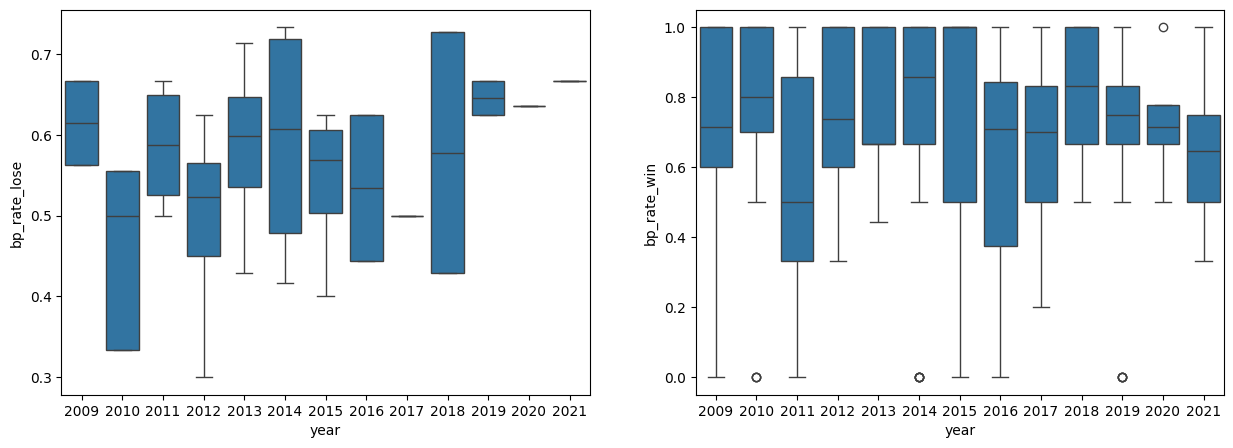

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x = 'year', y = 'bp_rate_lose', data = fin_game_103819, ax=axes[0])
sns.boxplot(x = 'year', y = 'bp_rate_win', data = fin_game_103819, ax=axes[1])

In [56]:
id_104925 = games_2022[games_2022['winner_id'] == 104925]
id_104925.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'l_ace', 'l_df', 'l_svpt', 'l_bpSaved', 'l_bpFaced',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points', 'score_list' , 'sets'], axis = 1, inplace = True)
id_104925['year'] = (id_104925['tourney_date']).apply(lambda x: int(str(x)[:4]))
id_104925['bp_rate_win'] = id_104925['w_bpSaved']/id_104925['w_bpFaced']
id_104925.drop(['tourney_date', 'w_bpSaved', 'w_bpFaced'], axis = 1, inplace = True)
id_104925_lose = games_2022[games_2022['loser_id'] == 104925]
id_104925_lose.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'l_ace', 'l_df', 'l_svpt',  'w_bpSaved', 'w_bpFaced',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points', 'score_list' , 'sets'], axis = 1, inplace = True)
id_104925_lose['year'] = (id_104925_lose['tourney_date']).apply(lambda x: int(str(x)[:4]))
id_104925_lose['bp_rate_lose'] = id_104925_lose['l_bpSaved']/id_104925_lose['l_bpFaced']
id_104925_lose.drop(['tourney_date', 'l_bpSaved', 'l_bpFaced'], axis = 1, inplace = True)
fin_game_104925 = id_104925_lose.merge(id_104925, how = 'outer', on = 'year')
fin_game_104925 = fin_game_104925[fin_game_104925['year'] > 2008]
fin_game_104925['year'] = fin_game_104925['year'].astype('category')

<ipython-input-56-254a7efe2064>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_104925.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
<ipython-input-56-254a7efe2064>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_104925['year'] = (id_104925['tourney_date']).apply(lambda x: int(str(x)[:4]))
<ipython-input-56-254a7efe2064>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Axes: xlabel='year', ylabel='bp_rate_win'>

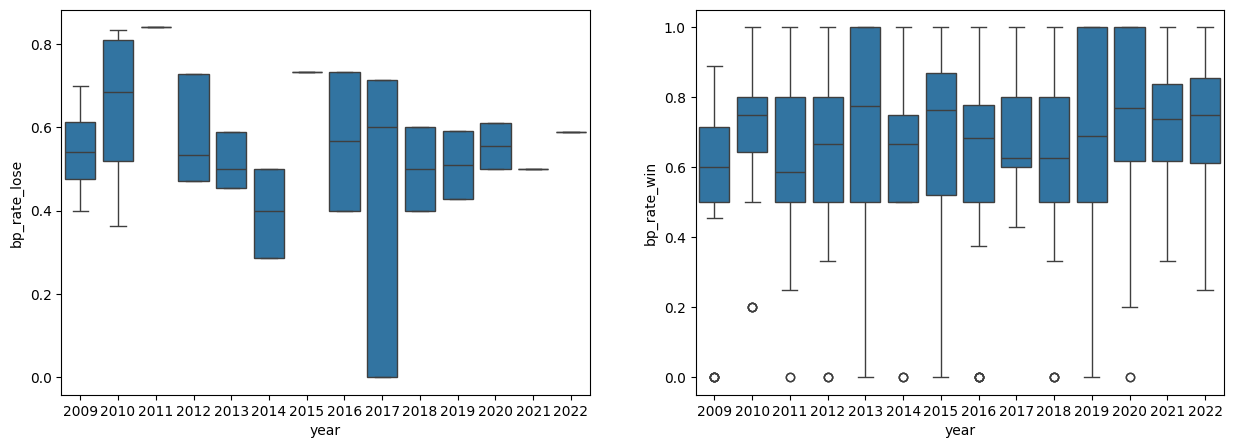

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x = 'year', y = 'bp_rate_lose', data = fin_game_104925, ax=axes[0])
sns.boxplot(x = 'year', y = 'bp_rate_win', data = fin_game_104925, ax=axes[1])

In [58]:
id_104745 = games_2022[games_2022['winner_id'] == 104745]
id_104745.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'l_ace', 'l_df', 'l_svpt', 'l_bpSaved', 'l_bpFaced',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points', 'score_list' , 'sets'], axis = 1, inplace = True)
id_104745['year'] = (id_104745['tourney_date']).apply(lambda x: int(str(x)[:4]))
id_104745['bp_rate_win'] = id_104745['w_bpSaved']/id_104745['w_bpFaced']
id_104745.drop(['tourney_date', 'w_bpSaved', 'w_bpFaced'], axis = 1, inplace = True)
id_104745_lose = games_2022[games_2022['loser_id'] == 104745]
id_104745_lose.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'l_ace', 'l_df', 'l_svpt',  'w_bpSaved', 'w_bpFaced',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points', 'score_list' , 'sets'], axis = 1, inplace = True)
id_104745_lose['year'] = (id_104745_lose['tourney_date']).apply(lambda x: int(str(x)[:4]))
id_104745_lose['bp_rate_lose'] = id_104745_lose['l_bpSaved']/id_104745_lose['l_bpFaced']
id_104745_lose.drop(['tourney_date', 'l_bpSaved', 'l_bpFaced'], axis = 1, inplace = True)
fin_game_104745 = id_104745_lose.merge(id_104745, how = 'outer', on = 'year')
fin_game_104745 = fin_game_104745[fin_game_104745['year'] > 2008]
fin_game_104745['year'] = fin_game_104745['year'].astype('category')

<ipython-input-58-9664a644a482>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_104745.drop(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
<ipython-input-58-9664a644a482>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_104745['year'] = (id_104745['tourney_date']).apply(lambda x: int(str(x)[:4]))
<ipython-input-58-9664a644a482>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Axes: xlabel='year', ylabel='bp_rate_win'>

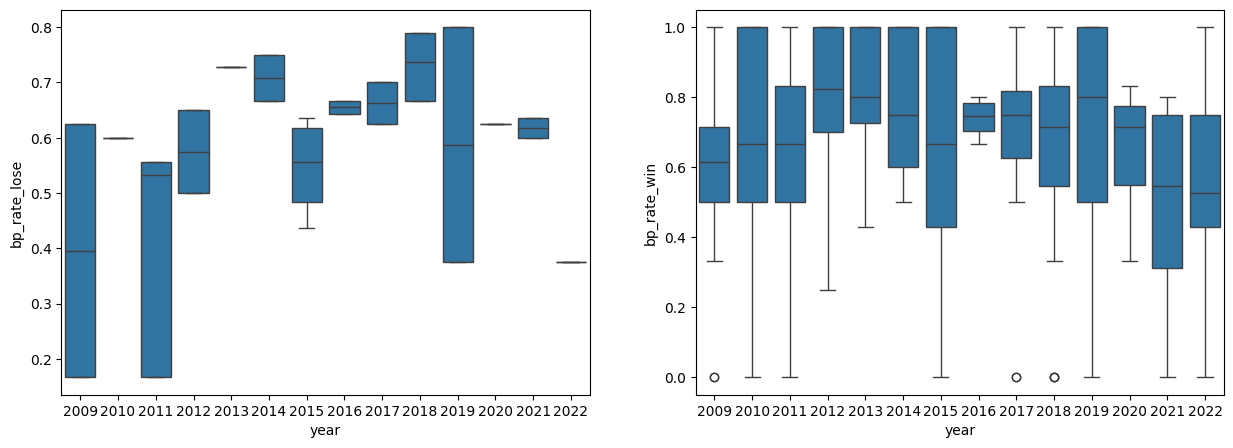

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x = 'year', y = 'bp_rate_lose', data = fin_game_104745, ax=axes[0])
sns.boxplot(x = 'year', y = 'bp_rate_win', data = fin_game_104745, ax=axes[1])

In [60]:
fin_game_103819['year'] = fin_game_103819['year'].apply(lambda x: int(x))
lose_103819 = fin_game_103819.groupby('year').agg({'bp_rate_lose':'mean'}).reset_index()
win_103819 = fin_game_103819.groupby('year').agg({'bp_rate_win':'mean'}).reset_index()

In [195]:
# Тест Шапиро-Уилка
alpha = 0.05
_, p = shapiro(lose_103819)
print('p=%.3f' % p)

p=0.000


In [197]:
alpha = 0.05
_, p = shapiro(win_103819)
print('p=%.3f' % p)

p=0.000


In [61]:
#Тест Краскела-Уолиса  для проверки гипотезы о равенстве средних значений нескольких групп
lpha = 0.05

_, p = stats.kruskal(win_103819['bp_rate_win'], lose_103819['bp_rate_lose'])
print('p=%.3f' % p)

p=0.001


In [62]:
fin_game_104925['year'] = fin_game_104925['year'].apply(lambda x: int(x))
lose_104925 = fin_game_104925.groupby('year').agg({'bp_rate_lose':'mean'}).reset_index()
win_104925 = fin_game_104925.groupby('year').agg({'bp_rate_win':'mean'}).reset_index()

In [63]:
alpha = 0.05
_, p = shapiro(win_104925)
print('p=%.3f' % p)

p=0.000


In [64]:
# Тест Крискела-Уолиса
alpha = 0.05

_, p = stats.kruskal(win_104925['bp_rate_win'], lose_104925['bp_rate_lose'])
print('p=%.3f' % p)

p=0.003


In [65]:
fin_game_104745['year'] = fin_game_104745['year'].apply(lambda x: int(x))
lose_104745 = fin_game_104745.groupby('year').agg({'bp_rate_lose':'mean'}).reset_index()
win_104745 = fin_game_104745.groupby('year').agg({'bp_rate_win':'mean'}).reset_index()

In [66]:
# Тест Шапиро-Уилка

alpha = 0.05
_, p = shapiro(win_104745)
print('p=%.3f' % p)

p=0.000


In [67]:
alpha = 0.05
_, p = shapiro(lose_104745)
print('p=%.3f' % p)

p=0.000


In [68]:
#Тест Краскела-Уолиса

alpha = 0.05

_, p = stats.kruskal(win_104745['bp_rate_win'], lose_104745['bp_rate_lose'])
print('p=%.3f' % p)

p=0.039


In [100]:
# Результаты игры зависят от того, как распределены выигранные брейкпойнты (отклоняем нулевую гипотезу)
#создадим новый признак "разница брейкпойнтов", который будет равен числу выигранных брейкпоинтов минус числу проигранных брейкпоинтов для каждого игрока. Этот признак покажет, насколько успешно игрок использует возможности для отбивания соперника и насколько успешно соперники отбивают его брейкпоинты.

win_lose_103819 = lose_103819.merge(win_103819, on ='year')
win_lose_103819['diff'] = win_lose_103819['bp_rate_win'] - win_lose_103819['bp_rate_lose']
win_lose_103819.drop(['bp_rate_lose', 'bp_rate_win'], axis = 1, inplace = True)


In [71]:
### Ntcn Ifgbhj-Ebkrf
alpha = 0.05
_, p = shapiro(win_lose_103819)
print('p=%.3f' % p)

p=0.000


In [72]:
win_lose_104745 = lose_104745.merge(win_104745, on ='year')
win_lose_104745['diff'] = win_lose_104745['bp_rate_win'] - win_lose_104745['bp_rate_lose']
win_lose_104745.drop(['bp_rate_lose', 'bp_rate_win'], axis = 1, inplace = True)

In [73]:
alpha = 0.05
_, p = shapiro(win_lose_104745)
print('p=%.3f' % p)

p=0.000


In [75]:
#Добавляем столбец, который будет содержать разницу.

win_lose_104925 = lose_104925.merge(win_104925, on ='year')
win_lose_104925['diff'] = win_lose_104925['bp_rate_win'] - win_lose_104925['bp_rate_lose']
win_lose_104925.drop(['bp_rate_lose', 'bp_rate_win'], axis = 1, inplace = True)

In [76]:
alpha = 0.05
_, p = shapiro(win_lose_104925)
print('p=%.3f' % p)

p=0.000


In [79]:
# Используем тест Вилкоксона для сравнения двух независимых выборок
alpha = 0.05

_, p = stats.wilcoxon(win_lose_104745['diff'], win_lose_104925['diff'])
print(p)

0.625732421875


In [ ]:
#Средние разницы между выигранными и проигранными брейкпоинтами для игроков 104745 и 104925 одинаковы.

In [80]:
# Тест Манна-Уитни

alpha = 0.05

_, p_value = mannwhitneyu(win_lose_103819['diff'], win_lose_104925['diff'])

print('p-value: ', p_value)

p-value:  0.512401349804485


In [ ]:
# Нет статистически значимой разницы между средним количеством выигранных брейкпоинтов у игроков 103819 и 104925 в выигранных и проигранных матчах. Поэтому мы принимаем нулевую гипотезу о равенстве средних значений.

In [81]:
alpha = 0.05

_, p_value = mannwhitneyu(win_lose_104745['diff'], win_lose_104925['diff'])

print('p-value: ', p_value)
# Проверка статистической значимости различий

p-value:  0.47634772226738475


In [83]:
alpha = 0.05

_, p_value = mannwhitneyu(win_lose_104745['diff'], win_lose_103819['diff'])

print('p-value: ', p_value)

p-value:  0.2344826070931848


Как распределяются выигранные брейкпоинты влияет на результат игры. На графиках можно заметить, что в матчах, которые победил игрок, выигранные брейкпоинты распределены равномернее, что свидетельствует о его дисциплинированности. Нет значительной разницы между игроками.

In [92]:
### Задание 5

lose_104925_more_med = lose_104925[lose_104925['bp_rate_lose']> statistics.median(lose_104925['bp_rate_lose'])]
lose_104925_less_med = lose_104925[lose_104925['bp_rate_lose']< statistics.median(lose_104925['bp_rate_lose'])]

In [95]:
win_104925_more_med = win_104925[win_104925['bp_rate_win']> statistics.median(win_104925['bp_rate_win'])]
win_104925_less_med = win_104925[win_104925['bp_rate_win']< statistics.median(win_104925['bp_rate_win'])]

In [96]:

alpha = 0.05
_, p = shapiro(win_104925_more_med)
print('p=%.3f' % p)

p=0.000


In [97]:
# нулевая и альтернативная гипотезы

alpha = 0.05

_, p_value = mannwhitneyu(win_104925_more_med['bp_rate_win'], lose_104925_more_med['bp_rate_lose'])

print('p-value: ', p_value)


p-value:  0.20862470862470864


In [98]:
# нулевая и альтернативная гипотезы

alpha = 0.05

_, p_value = mannwhitneyu(win_104925_less_med['bp_rate_win'], lose_104925_less_med['bp_rate_lose'])

print('p-value: ', p_value)

p-value:  0.0021407097315851212


Отвергаем нулевую гипотезу и принимаем альтернативную гипотезу, утверждающую, что существует зависимость между результатом игры и количеством выигранных брейкпоинтов, превышающих медианное значение. Таким образом, можно сделать вывод, что победа в игре зависит от количества брейкпоинтов, превышающих медиану.